# Assignment 1

#### imports

In [48]:
import json
import re
from typing import List, Callable, Dict
from collections import OrderedDict
import numpy as np
import pandas as pd
from tqdm import tqdm
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import gensim
import gensim.downloader as gloader
import umap
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
import copy
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
from torchinfo import summary
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Task 1

In [4]:
def dataset_from_json(name):
    from collections import Counter
    with open(name, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame.from_dict(data, orient='index')
        df = df[['id_EXIST', 'lang', 'tweet', 'labels_task2']]
        df = df.rename(columns={'labels_task2': 'label'})
        df = df[df['lang'] == 'en']

        def most_frequent_or_drop(arr):
            if not isinstance(arr, list):
                return arr
            c = Counter(arr)
            most_common = c.most_common()
            if len(most_common) == 0:
                return None
            max_count = most_common[0][1]
            candidates = [val for val,
                          count in most_common if count == max_count]
            if len(candidates) > 1:
                return None
            return candidates[0]

        df['label'] = df['label'].apply(most_frequent_or_drop)

        def map_label(label):
            mapping = {
                '-': 0,
                'DIRECT': 1,
                'JUDGEMENTAL': 2,
                'REPORTED': 3
            }
            return mapping.get(label, None)
        
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].apply(map_label)

    return df

train_df_np = dataset_from_json('data/training.json')
val_df_np = dataset_from_json('data/validation.json')
test_df_np = dataset_from_json('data/test.json')

In [5]:
train_df_np.head()
# test_df_np.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


### Visualize the classes

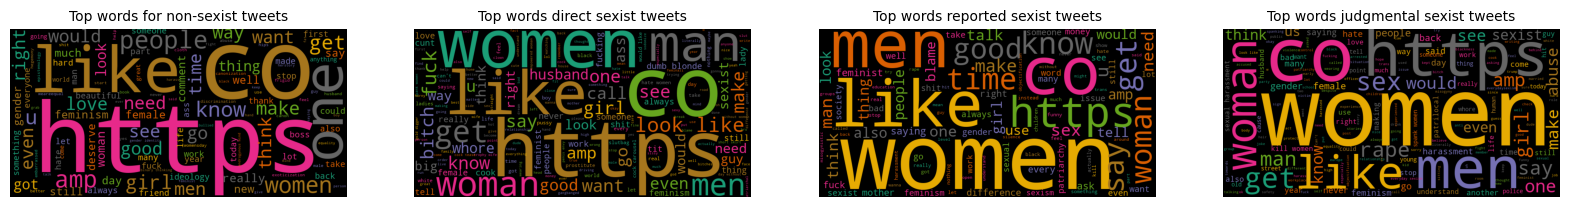

In [6]:
n_posts = 1000
stop = set(stopwords.words('english'))
q_NS = ' '.join(train_df_np[train_df_np['label'] == 0]['tweet'].str.lower().values[:n_posts])
q_DS = ' '.join(train_df_np[train_df_np['label'] == 1]['tweet'].str.lower().values[:n_posts])
q_RS = ' '.join(train_df_np[train_df_np['label'] == 2]['tweet'].str.lower().values[:n_posts])
q_JS = ' '.join(train_df_np[train_df_np['label'] == 3]['tweet'].str.lower().values[:n_posts])

wordcloud_NS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_NS)
wordcloud_DS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_DS)
wordcloud_RS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_RS)
wordcloud_JS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_JS)

fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(wordcloud_NS)
ax[0].set_title('Top words for non-sexist tweets',fontsize = 10)
ax[0].axis("off")

ax[1].imshow(wordcloud_DS)
ax[1].set_title('Top words direct sexist tweets',fontsize = 10)
ax[1].axis("off")

ax[2].imshow(wordcloud_RS)
ax[2].set_title('Top words reported sexist tweets',fontsize = 10)
ax[2].axis("off")

ax[3].imshow(wordcloud_JS)
ax[3].set_title('Top words judgmental sexist tweets',fontsize = 10)
ax[3].axis("off")

plt.show()

## Task 2

In [7]:
stop_words = set(stopwords.words('english'))  # set di stopwords inglesi

def clean_text(text: str) -> str:
    """Remove emojis, URLs, mentions, hashtags, special characters, extra spaces, and stopwords."""
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)  # remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'["\'`\’\‘\“\”]', ' ', text)  # remove extra quotes

    # rimuovi stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words).strip()

def lemmatize_text(text: str) -> str:
    """Lemmatize text using POS tagging for more accurate results."""
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

def text_preprocessing(df, column='tweet', pipeline=None):
    """
    Apply a sequence of preprocessing functions to a dataframe column.

    Parameters:
    - df: pandas DataFrame
    - column: name of the text column
    - pipeline: list of functions to apply sequentially
    """
    df = df.copy()
    if pipeline is None:
        pipeline = [clean_text, lemmatize_text]

    for func in pipeline:
        df[column] = df[column].apply(func)

    return df

In [8]:
pipeline = [clean_text, lemmatize_text]

train_df = text_preprocessing(train_df_np, pipeline=pipeline)
val_df = text_preprocessing(val_df_np, pipeline=pipeline)
test_df = text_preprocessing(test_df_np, pipeline=pipeline)

In [9]:
train_df.head()
# test_df.head()

,id_EXIST,lang,tweet,label
200001,200001,en,ffs lay blame bastard murder novel idea know,0
200002,200002,en,write uni essay local pub coffee random old ma...,3
200003,200003,en,dont appreciate two ride team member look behi...,3
200004,200004,en,unacceptable use title men interview fact seni...,0
200005,200005,en,make hard target basically boil make sure targ...,0


## Task 3 - old

### Create the vocabulary

In [29]:
idx_to_word = OrderedDict()
word_to_idx = OrderedDict()

# encoding of the unknown token for oov val/test words
word_to_idx["<UNK>"] = 0
idx_to_word[0] = "<UNK>"

curr_idx = 1
for sentence in tqdm(train_df.tweet.values):
    tokens = sentence.split()
    for token in tokens:
        if token not in word_to_idx:
            word_to_idx[token] = curr_idx
            idx_to_word[curr_idx] = token
            curr_idx += 1
word_listing = list(idx_to_word.values())
vocab_size = len(idx_to_word)

100%|██████████| 2873/2873 [00:00<00:00, 70299.02it/s]


check the vocabulary

In [30]:
assert len(idx_to_word) == len(word_to_idx)
assert len(idx_to_word) == len(word_listing)
for i in tqdm(range(0, len(idx_to_word))):
    assert idx_to_word[i] in word_to_idx
    assert word_to_idx[idx_to_word[i]] == i

100%|██████████| 9458/9458 [00:00<00:00, 993830.22it/s]


save the vocabulary

In [212]:
vocab_path = './data/vocab.json'

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    json.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to ./data/vocab.json
Saving completed!


### Embed the vocabulary

In [37]:
def embedding_from_context(train_df, word, embedding_dict, context_size=3, embedding_dimension=50):
    """Generate an embedding for an out-of-vocabulary word as average of its context in the training data."""
    try:
        for seq in train_df.tweet.values:
            tokens = seq.split()
            if word in tokens:
                pos = tokens.index(word)
                start = max(0, pos - context_size)
                end = min(len(tokens), pos + context_size + 1)
                context_words = [t for t in tokens[start:end] if t != word]
                break
        context_embeddings = []
        for context_word in context_words:
            try:
                context_embeddings.append(embedding_dict[word_to_idx[context_word]])
            except KeyError:
                # if the context word is also oov, skip it
                continue
        if not len(context_embeddings) > 2:
            raise ValueError("Not enough context embeddings found")
        
        embedding = np.mean(context_embeddings, axis=0)
    except Exception as e:
        embedding = np.random.uniform(low=-3, high=3, size=embedding_dimension)
        print(f"Random embedding generated for OOV word: {word}")

    return embedding

def embedding_as_subwords(word, glove, n=3):
    subwords = [word[i:i+n] for i in range(len(word)-n+1)]
    known_subs = [glove[sub] for sub in subwords if sub in glove]
    if known_subs:
        return np.mean(known_subs, axis=0)
    else:
        return np.mean(glove.vectors, axis=0)  # fallback: average vector

def embedding_from_similarity(word, glove, scorer='ratio', top_k=1, min_score=70):
    vocab_list = glove.index_to_key
    scorer_fn = getattr(fuzz, scorer)
    # Find top_k closest matches by fuzzy similarity
    matches = process.extract(word, vocab_list, limit=top_k, scorer=scorer_fn)
    # Filter out low-similarity matches
    valid_matches = [(w, s) for w, s, _ in matches if s >= min_score]

    if not valid_matches:
        return np.mean(glove.vectors, axis=0)

    # Weighted average of matched embeddings by similarity score
    vectors, weights = [], []
    for w, score in valid_matches:
        vectors.append(glove[w])
        weights.append(score)

    weights = np.array(weights) / np.sum(weights)
    return np.average(vectors, axis=0, weights=weights)

def embed_oov_words(oov_words, embedding_dict, embedding_model, embedding_dimension=50, oov_solution="random"):
    """Handle out-of-vocabulary words"""
    print("OOV words: ", oov_words)
    if oov_solution == "random":
        # embed the training oov words with random vectors
        for word in oov_words:
            embedding_vector = np.random.uniform(low=-3, high=3, size=embedding_dimension)
            embedding_dict[word_to_idx[word]] = embedding_vector
    elif oov_solution == "context":
        # embed the training oov words with context-based vectors
        for word in oov_words:
            embedding_vector = embedding_from_context(train_df, word, embedding_dict, context_size=5)
            embedding_dict[word_to_idx[word]] = embedding_vector
    elif oov_solution == "mean":
        mean_embedding = np.mean(list(embedding_dict.values()), axis=0)
        for word in oov_words:
            noise = np.random.normal(0, 1, mean_embedding.shape)
            embedding_vector = mean_embedding + noise
            embedding_dict[word_to_idx[word]] = embedding_vector
    elif oov_solution == "subwords" and embedding_model is not None:
        for word in oov_words:
            embedding_vector = embedding_as_subwords(word, embedding_model, n=3)
            embedding_dict[word_to_idx[word]] = embedding_vector
    elif oov_solution == "similarity" and embedding_model is not None:
        for word in oov_words:
            embedding_vector = embedding_from_similarity(word, embedding_model, top_k=3)
            embedding_dict[word_to_idx[word]] = embedding_vector
    elif oov_solution == "none":
        pass
    else:
        raise ValueError("Invalid OOV solution specified")
    return embedding_dict

In [104]:
# download model
download_path = "glove-wiki-gigaword-{}".format(50)
embedding_model = gloader.load(download_path)

In [32]:
def glove_embed_vocabulary(word_to_idx, embedding_dimension=50, oov_solution="random"):
    # # download model
    # download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # embedding_model = gloader.load(download_path)

    # check training oov words
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    oov_terms = list(oov)
    oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
    print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

    # build the embedding matrix
    # embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    embedding_dict = {}
    oov_words = []
    for word, idx in tqdm(list(word_to_idx.items())[1:]):
        try:
            embedding_vector = embedding_model[word]
            embedding_dict[idx] = embedding_vector
        except (KeyError, TypeError):
            oov_words.append(word)

    # handle oov words
    embedding_dict = embed_oov_words(oov_words, embedding_dict, embedding_model, embedding_dimension, oov_solution)

        # check that all the training oov words have been correctly encoded
    if oov_solution != "none":
        for word in oov_words:
            embedding_dict[word_to_idx[word]] = embedding_vector
            assert not np.any(np.isnan(embedding_dict[word_to_idx[word]])), f"NaN found in embedding for OOV word: {word}"


    # static embedding for val and test oov
    oov_val_test_num = 0
    oog_val_test_num = 0
    UNK_idx = 0
    global curr_idx
    embedding_dict[UNK_idx] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
    for sentence in tqdm(val_df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                try:
                    embedding_vector = embedding_model[token]
                    embedding_dict[curr_idx] = embedding_vector
                    word_to_idx[token] = curr_idx
                    idx_to_word[curr_idx] = token
                    curr_idx += 1
                    oov_val_test_num+=1
                except KeyError:
                    oog_val_test_num+=1
                    word_to_idx[token] = UNK_idx
    for sentence in tqdm(test_df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                try:
                    embedding_vector = embedding_model[token]
                    embedding_dict[curr_idx] = embedding_vector
                    word_to_idx[token] = curr_idx
                    idx_to_word[curr_idx] = token
                    curr_idx += 1
                    oov_val_test_num+=1
                except KeyError:
                    oog_val_test_num+=1
                    word_to_idx[token] = UNK_idx

    embedding_matrix = np.zeros((len(list(embedding_dict.keys())), embedding_dimension), dtype=np.float32)
    for idx in range(len(list(embedding_dict.keys()))):
        embedding_matrix[idx] = embedding_dict[idx]

    return embedding_matrix

In [33]:
glove_50_embedding_model = glove_embed_vocabulary(word_to_idx, embedding_dimension=50, oov_solution="subwords")

Total OOV terms: 1718 (18.16%)


100%|██████████| 9457/9457 [00:00<00:00, 38364.29it/s]


OOV words:  ['emoji', 'godcolette', 'anywheregood', 'gamergate', 'journo', 'altright', 'breadtube', 'impassion', 'releasethus', 'comicsgate', 'shitstorm', 'incels', 'peachfuzz', 'futanari', 'shouldve', 'gamergates', 'theythis', 'angeryou', 'bitchesid', 'downvoted', 'proofunless', 'dosay', 'bcuz', 'exhusband', 'allegationsjudge', 'mgtow', 'incel', 'baaki', 'promale', 'bahut', 'mramgtowincel', 'womanhating', 'angriesbecause', 'chomos', 'qristianity', 'femcels', 'nigcels', 'hoteps', 'dvestors', 'lolthe', 'catastrophizing', 'outbiggest', 'evergrowing', 'menwho', 'redpill', 'blackpilado', 'ironicamente', 'earlierwhy', 'standardoh', 'guidedont', 'waaaaaater', 'interestbring', 'transwe', 'notallmen', 'vaginanot', 'oppressionthey', 'predatorsopperssors', 'lookact', 'thisthat', 'retweetsnintendo', 'switchsportsnotallmenwow', 'upstop', 'youve', 'checkif', 'decentish', 'heckin', 'consentjust', 'dck', 'girdusky', 'prowhite', 'heathensno', 'transphobes', 'idk', 'bossah', 'overcode', 'talaks', 'viol

100%|██████████| 280/280 [00:00<00:00, 62302.66it/s]


In [37]:
# glove_100_embedding_model = glove_embed_vocabulary(word_to_idx, 100, "random")

In [34]:
co_occurrence_matrix = co_occurrence_count(train_df,
                                           idx_to_word,
                                           word_to_idx,
                                           window_size=4)

100%|██████████| 2873/2873 [00:00<00:00, 10212.80it/s]


#### visualize the emmbeddings

In [38]:
def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.
    """
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)
    
    return reduced

In [39]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    :param word_annotations: list of words to be annotated.
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

Annotating words: ['blink', 'reduce', 'similar']


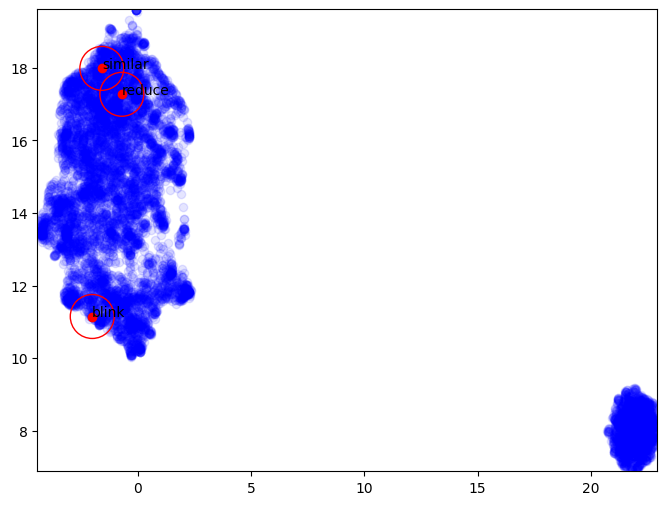

In [251]:
reduced_embedding_umap = reduce_umap(glove_50_embedding_model)
# visualize_embeddings(reduced_embedding_umap,
#                      ['good', 'love', 'beautiful', 'emoji'],
#                      word_to_idx)
for i in range(1):
    rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
    visualize_embeddings(reduced_embedding_umap,
                    rand_words,
                    word_to_idx)

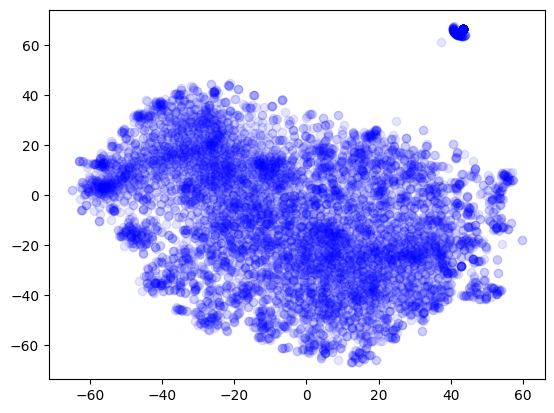

In [252]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(glove_50_embedding_model[:])
plt.scatter(Y[:, 0], Y[:, 1], alpha=0.1, c='blue')
plt.show()

In [42]:
# reduced_embedding_100_umap = reduce_umap(glove_100_embedding_model)
# visualize_embeddings(reduced_embedding_100_umap,
#                      ['good', 'love', 'beautiful'],
#                      word_to_idx)

## Task 3 - new

### Build the vocabulary

In [10]:
def build_vocabulary(
    df: pd.DataFrame,
    column_name: str = "tweet",
    add_special_tokens: bool = True
):
    """
    Builds a complete vocabulary from a DataFrame column.
    Returns mappings (idx_to_word, word_to_idx), word listing, and frequency DataFrame.

    :param df: DataFrame containing the text column.
    :param column_name: Name of the column to process.
    :param add_special_tokens: Whether to include <PAD> and <UNK> tokens.
    :return:
        - idx_to_word (OrderedDict[int, str])
        - word_to_idx (OrderedDict[str, int])
        - word_listing (List[str])
        - vocab_df (pd.DataFrame with 'vocabulary' and 'counts')
    """

    # Crea una lista di token da tutte le frasi
    text_array = df[column_name].values
    list_of_token_lists = [t.split() for t in text_array]
    repeated_vocab = np.concatenate(list_of_token_lists)
    repeated_vocab = repeated_vocab[repeated_vocab != ""]  # rimuove vuoti

    # Conta la frequenza di ogni parola
    token_array, counts_array = np.unique(repeated_vocab, return_counts=True)

    # Ordina per frequenza decrescente
    sorted_indices = np.argsort(-counts_array)
    token_array = token_array[sorted_indices].tolist()
    counts_array = counts_array[sorted_indices]

    # Crea mapping ordinati
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    if add_special_tokens:
        for tok in ["<PAD>", "<UNK>"]:
            word_to_idx[tok] = curr_idx
            idx_to_word[curr_idx] = tok
            curr_idx += 1

    for token in tqdm(token_array, desc="Building vocabulary"):
        word_to_idx[token] = curr_idx
        idx_to_word[curr_idx] = token
        curr_idx += 1

    # Costruisci lista parole e DataFrame
    word_listing = list(idx_to_word.values())
    vocab_df = pd.DataFrame({"vocabulary": token_array, "counts": counts_array})

    return idx_to_word, word_to_idx, word_listing, vocab_df

In [11]:
idx_to_word, word_to_idx, word_listing, vocab_df = build_vocabulary(train_df)

print("Size:", len(word_to_idx))
print("Most common words:\n", vocab_df.head(10))
print("Example mapping:", list(word_to_idx.items())[:10])

Building vocabulary: 100%|██████████| 9457/9457 [00:00<00:00, 2060868.34it/s]

Size: 9459
Most common words:
   vocabulary  counts
0      woman     734
1       like     509
2        get     334
3       dont     322
4       make     246
5         go     242
6        say     237
7        men     225
8         im     222
9       know     218
Example mapping: [('<PAD>', 0), ('<UNK>', 1), ('woman', 2), ('like', 3), ('get', 4), ('dont', 5), ('make', 6), ('go', 7), ('say', 8), ('men', 9)]


#### Evaluate the vocabulary

In [12]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
    check_default_size: bool = False
):
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing, _ = build_vocabulary(df)
    _, _, second_word_listing, _ = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [13]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("")
print("Evaluation completed!")

Vocabulary evaluation...


Building vocabulary: 100%|██████████| 9457/9457 [00:00<00:00, 2069794.04it/s]


Evaluation completed!


#### Check the vocabulary

In [14]:
vocab_path = './data/vocab.json'

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    json.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to ./data/vocab.json
Saving completed!


### OOV words

In [15]:
embedding_dimension = 50
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
embedding_model = gloader.load(download_path)

In [16]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [17]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(oov_terms[:3])

Total OOV terms: 1719 (18.17%)
['siyas', 'truefender', 'preenlightenment']


### Embedding

In [18]:
def embedding_from_context(train_df, word, embedding_dict, context_size=3, embedding_dimension=50):
    """Generate an embedding for an out-of-vocabulary word as average of its context in the training data."""
    try:
        for seq in train_df.tweet.values:
            tokens = seq.split()
            if word in tokens:
                pos = tokens.index(word)
                start = max(0, pos - context_size)
                end = min(len(tokens), pos + context_size + 1)
                context_words = [t for t in tokens[start:end] if t != word]
                break
        context_embeddings = []
        for context_word in context_words:
            try:
                context_embeddings.append(embedding_dict[word_to_idx[context_word]])
            except KeyError:
                # if the context word is also oov, skip it
                continue
        if not len(context_embeddings) > 2:
            raise ValueError("Not enough context embeddings found")
        
        embedding = np.mean(context_embeddings, axis=0)
    except Exception as e:
        embedding = np.random.uniform(low=-3, high=3, size=embedding_dimension)
        print(f"Random embedding generated for OOV word: {word}")

    return embedding

def embedding_as_subwords(word, glove, n=3):
    subwords = [word[i:i+n] for i in range(len(word)-n+1)]
    known_subs = [glove[sub] for sub in subwords if sub in glove]
    if known_subs:
        return np.mean(known_subs, axis=0)
    else:
        return np.mean(glove.vectors, axis=0)  # fallback: average vector

def embedding_from_similarity(word, glove, scorer='ratio', top_k=1, min_score=70):
    vocab_list = glove.index_to_key
    scorer_fn = getattr(fuzz, scorer)
    # Find top_k closest matches by fuzzy similarity
    matches = process.extract(word, vocab_list, limit=top_k, scorer=scorer_fn)
    # Filter out low-similarity matches
    valid_matches = [(w, s) for w, s, _ in matches if s >= min_score]

    if not valid_matches:
        return np.mean(glove.vectors, axis=0)

    # Weighted average of matched embeddings by similarity score
    vectors, weights = [], []
    for w, score in valid_matches:
        vectors.append(glove[w])
        weights.append(score)

    weights = np.array(weights) / np.sum(weights)
    return np.average(vectors, axis=0, weights=weights)

In [19]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension: int,
    word_to_idx: Dict[str, int],
    vocab_size: int,
    oov_terms: List[str] = None,
    unk_token: str = "<UNK>",
    oov_strategy: str = "random",
    random_seed: int = 42
) -> torch.Tensor:
    """
    Builds an embedding matrix for a dataset, handling OOV and <UNK> tokens.

    :param embedding_model: pre-trained word embeddings (GloVe)
    :param embedding_dimension: dimensionality of embeddings
    :param word_to_idx: dictionary mapping words to indices
    :param vocab_size: total vocabulary size
    :param oov_terms: list of OOV terms from training set
    :param unk_token: token used for unseen words in val/test
    :param random_seed: for reproducibility of random embeddings
    :return: embedding matrix (torch.Tensor) of shape [vocab_size, embedding_dimension]
    """
    np.random.seed(random_seed)
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Precompute a random vector for <UNK>
    unk_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

    for word, idx in tqdm(word_to_idx.items(), desc="Building embedding matrix"):
        if word == unk_token:
            embedding_matrix[idx] = unk_vector
        else:
            try:
                embedding_vector = embedding_model[word]
            except KeyError:
                # OOV word 
                if oov_strategy == "random":
                    embedding_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)
                elif oov_strategy == "subwords":
                    embedding_vector = embedding_as_subwords(word, embedding_model, n=3)
            
            embedding_matrix[idx] = embedding_vector

    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix

In [20]:
vocab_size = len(word_to_idx)

embedding_matrix = build_embedding_matrix(
    embedding_model=embedding_model,
    embedding_dimension=embedding_dimension,
    word_to_idx=word_to_idx,
    vocab_size=vocab_size,
    oov_terms=oov_terms,
    unk_token="<UNK>",
    oov_strategy="subwords",
)

print()
print(embedding_matrix.shape)  # [vocab_size, embedding_dim]

Building embedding matrix:   0%|          | 0/9459 [00:00<?, ?it/s]

Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 18331.79it/s]


torch.Size([9459, 100])


In [21]:
def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.

    :return
      - co_occurrence symmetric matrix of size |V| x |V|
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size),
                                    dtype=np.float32)
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]
            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index,
                                         second_word_index] += 1
    return co_occurrence_matrix

In [22]:
co_occurrence_matrix = co_occurrence_count(train_df,
                                           idx_to_word,
                                           word_to_idx,
                                           window_size=4)

100%|██████████| 2873/2873 [00:00<00:00, 5473.05it/s]


### Embedding Visualization

In [23]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    :param word_annotations: list of words to be annotated.
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

In [24]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    :param embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    :return
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    svd = TruncatedSVD(n_components=2, n_iter=10)
    reduced = svd.fit_transform(embeddings)

    return reduced

def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.
    """
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)

    return reduced

In [25]:
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'umap': reduce_umap
    }

    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')

    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)

Annotating words: ['fefes', 'ultimate', 'consciousnessraising']


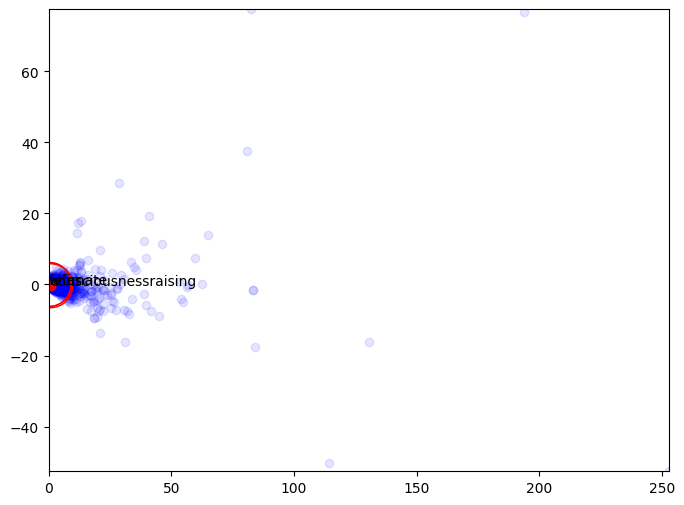

In [26]:
rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)

Annotating words: ['fefes', 'ultimate', 'consciousnessraising']


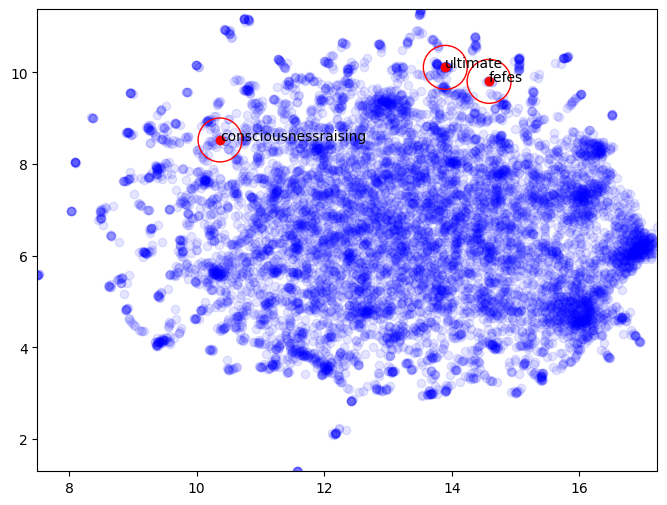

In [27]:
run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

## Task 4

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
lr = 1e-4
num_epochs = 10

Using device: cuda


In [29]:
def text_to_indices(text, word_to_idx, unk_token="<UNK>"):
    return [word_to_idx.get(t, word_to_idx[unk_token]) for t in text.split()]

### Tweet Dataset

In [90]:
class TweetDataset(Dataset):
    def __init__(self, df, word_to_idx, unk_token="<UNK>"):
        self.sequences = [text_to_indices(t, word_to_idx, unk_token) for t in df['tweet'].values]
        self.labels = df['label'].values.astype(int)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function per padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_seqs = rnn_utils.pad_sequence([torch.tensor(seq) for seq in sequences],
                                         batch_first=True, padding_value=word_to_idx["<PAD>"])
    labels = torch.tensor(labels)
    return padded_seqs, labels, lengths


train_loader = DataLoader(TweetDataset(train_df, word_to_idx), batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TweetDataset(val_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

### Bidirectional LSTM model

In [94]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=word_to_idx["<PAD>"])
        self.bilstm = nn.LSTM(input_size=embedding_dim,
                              hidden_size=hidden_dim,
                              num_layers=num_layers,
                              bidirectional=True,
                              batch_first=True,
                              dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                      batch_first=True,
                                                      enforce_sorted=False)
            packed_out, (h_n, c_n) = self.bilstm(packed)
        else:
            # se lengths non passato → usa sequenze intere (per summary)
            out, (h_n, c_n) = self.bilstm(embedded)

        # concatenazione hidden state
        h_forward = h_n[-2,:,:]
        h_backward = h_n[-1,:,:]
        h = torch.cat((h_forward, h_backward), dim=1)
        out = self.fc(h)
        return out

In [95]:
baseline_model = BiLSTMClassifier(embedding_matrix, hidden_dim=128, num_layers=1)
stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=128, num_layers=2)

In [96]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_model, input_size=(batch_size, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMClassifier                         [32, 4]                   --
├─Embedding: 1-1                         [32, 230, 100]            945,900
├─LSTM: 1-2                              [32, 230, 256]            235,520
├─Linear: 1-3                            [32, 4]                   1,028
Total params: 1,182,448
Trainable params: 1,182,448
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.76
Input size (MB): 0.06
Forward/backward pass size (MB): 20.96
Params size (MB): 4.73
Estimated Total Size (MB): 25.75

## Task 5

In [97]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc, prec, rec, f1

# training loop with checkpointing on validation accuracy
def train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device):
    best_val_acc = 0.0
    best_state = None
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': [],
    }
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = eval_epoch(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)
    
        print(f"Epoch {epoch}/{num_epochs} — train loss: {train_loss:.4f} — val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val prec: {val_prec:.4f}, val rec: {val_rec:.4f}, val f1: {val_f1:.4f}")
    
        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     best_state = copy.deepcopy(model.state_dict())
    
    # print("Training finished. Best val acc:", best_val_acc)
    # if best_state is not None:
    #     model.load_state_dict(best_state)
    #     print("Loaded best model state (best val acc =", best_val_acc, ")")
    
    return history

baseline tranining

In [98]:
baseline_model = baseline_model.to(device)
optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
baseline_model_history = train_loop(baseline_model, num_epochs, train_loader, val_loader, optimizer, criterion, device)


Epoch 1/10 — train loss: 1.1286 — val loss: 0.9637, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 2/10 — train loss: 0.9174 — val loss: 0.9376, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 2/10 — train loss: 0.9174 — val loss: 0.9376, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 3/10 — train loss: 0.8812 — val loss: 0.9039, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 3/10 — train loss: 0.8812 — val loss: 0.9039, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 4/10 — train loss: 0.8283 — val loss: 0.8435, val acc: 0.6867, val prec: 0.3576, val rec: 0.2452, val f1: 0.2068
Epoch 4/10 — train loss: 0.8283 — val loss: 0.8435, val acc: 0.6867, val prec: 0.3576, val rec: 0.2452, val f1: 0.2068
Epoch 5/10 — train loss: 0.7810 — val loss: 0.8146, val acc: 0.6933, val prec: 0.4252, val rec: 0.2561, val f1: 0.2246
Epoch 5/10 — train loss: 0.7810 — val loss: 0.81

stacked training

In [99]:
stacked_model = stacked_model.to(device)
optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device)


Epoch 1/10 — train loss: 1.0503 — val loss: 0.9441, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 2/10 — train loss: 0.9009 — val loss: 0.9194, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 2/10 — train loss: 0.9009 — val loss: 0.9194, val acc: 0.7000, val prec: 0.7000, val rec: 0.2500, val f1: 0.2059
Epoch 3/10 — train loss: 0.8503 — val loss: 0.8585, val acc: 0.7000, val prec: 0.3571, val rec: 0.2500, val f1: 0.2083
Epoch 3/10 — train loss: 0.8503 — val loss: 0.8585, val acc: 0.7000, val prec: 0.3571, val rec: 0.2500, val f1: 0.2083
Epoch 4/10 — train loss: 0.7852 — val loss: 0.8160, val acc: 0.7067, val prec: 0.5362, val rec: 0.2863, val f1: 0.2670
Epoch 4/10 — train loss: 0.7852 — val loss: 0.8160, val acc: 0.7067, val prec: 0.5362, val rec: 0.2863, val f1: 0.2670
Epoch 5/10 — train loss: 0.7440 — val loss: 0.7948, val acc: 0.7067, val prec: 0.5362, val rec: 0.2863, val f1: 0.2670
Epoch 5/10 — train loss: 0.7440 — val loss: 0.79

### Visualization

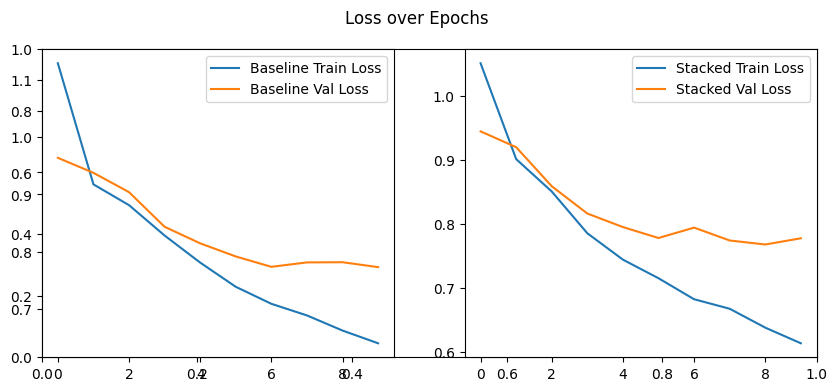

In [100]:
plt.subplots(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_model_history['train_loss'], label='Baseline Train Loss')
plt.plot(baseline_model_history['val_loss'], label='Baseline Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(stacked_model_history['train_loss'], label='Stacked Train Loss')
plt.plot(stacked_model_history['val_loss'], label='Stacked Val Loss')
plt.suptitle('Loss over Epochs')
plt.legend()
plt.show()

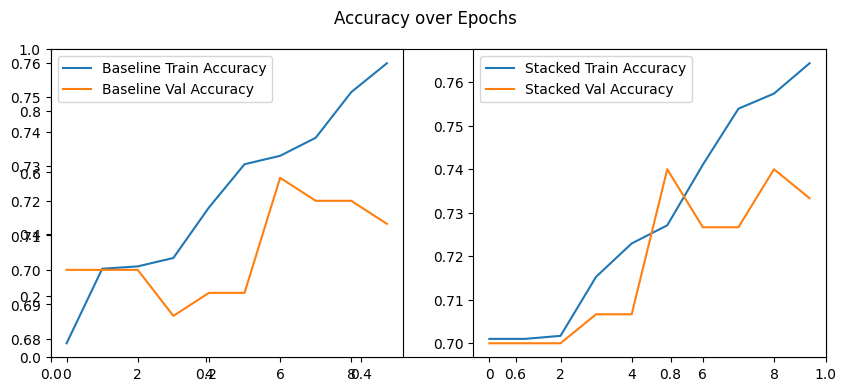

In [101]:
plt.subplots(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_model_history['train_acc'], label='Baseline Train Accuracy')
plt.plot(baseline_model_history['val_acc'], label='Baseline Val Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(stacked_model_history['train_acc'], label='Stacked Train Accuracy')
plt.plot(stacked_model_history['val_acc'], label='Stacked Val Accuracy')
plt.suptitle('Accuracy over Epochs')
plt.legend()
plt.show()

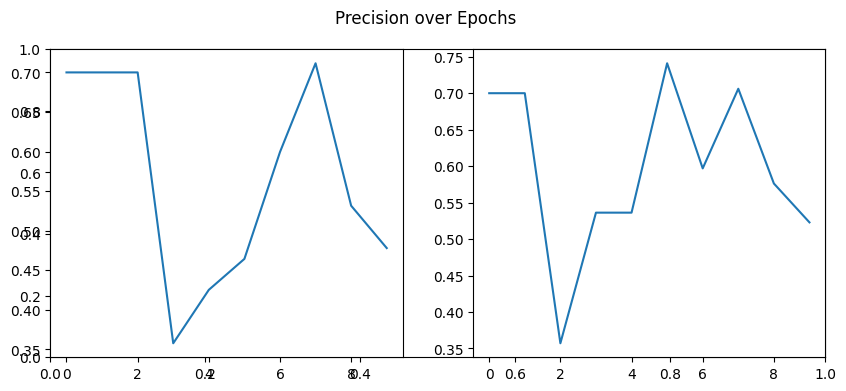

In [102]:
plt.subplots(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_model_history['val_prec'], label='Baseline Val Precision')
plt.subplot(1, 2, 2)
plt.plot(stacked_model_history['val_prec'], label='Stacked Val Precision')
plt.suptitle('Precision over Epochs')
plt.show()

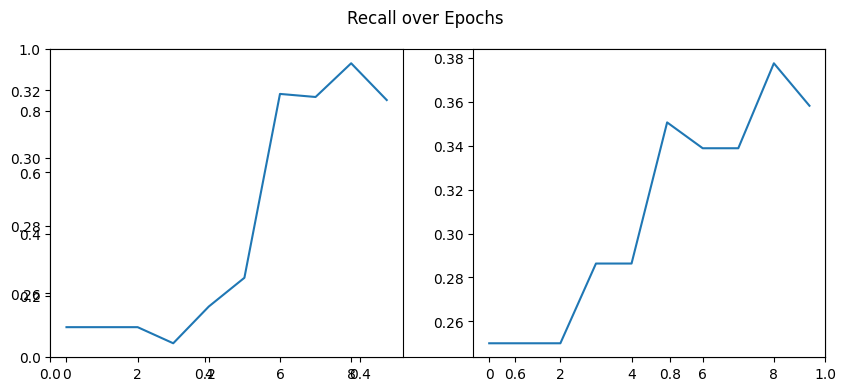

In [103]:
plt.subplots(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_model_history['val_rec'], label='Baseline Val Recall')
plt.subplot(1, 2, 2)
plt.plot(stacked_model_history['val_rec'], label='Stacked Val Recall')
plt.suptitle('Recall over Epochs')
plt.show()

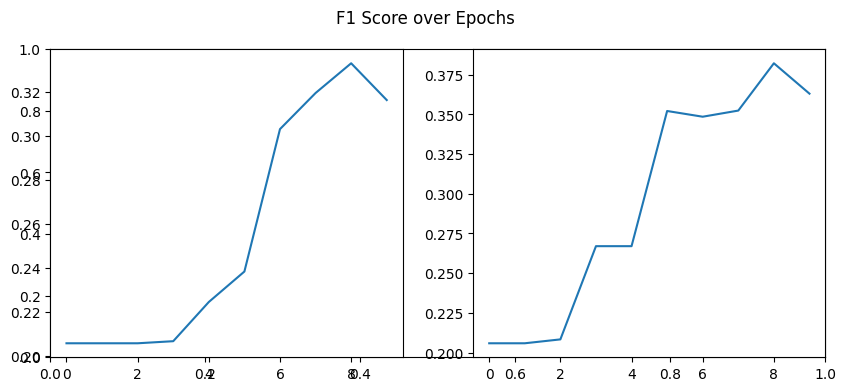

In [104]:
plt.subplots(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_model_history['val_f1'], label='Baseline Val F1')
plt.subplot(1, 2, 2)
plt.plot(stacked_model_history['val_f1'], label='Stacked Val F1')
plt.suptitle('F1 Score over Epochs')
plt.show()